# <span style="color:blue"> Coursera course: Introduction to Deep Learning </span>
## Week 3 assignment:  CNN Cancer Detection Kaggle Mini-Project

# <span style="color:green"> Kaggle competition: Histopathologic Cancer Detection: Identify metastatic tissue in histopathologic scans of lymph node sections </span>
### University of Colorado Boulder
### Taught by:Geena Kim , Assistant Teaching
### <span style="color:gray">Solution by: Miguel Duque B.</span> 
Date: December, 2022


# Table of contents
* [1. Brief description of the problem and data](#section1)
* [2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data](#section2)
* [3. Model Architecture](#section3)
* [4. Bonus: Data augmentation](#section4)
* [External references](#references)

# <span style="color:darkgray"> Change these options to run or to avoid running certain parts of the notebook </span>


In [1]:
# Change this to inspect for corrupt image files (no error founds in previous run)
check_image_files = False

# Reduce dataset size to run quick experiments with this notebook:
reduce_dataset_size = True

# Fit basic CNN model
train_basic_model = True # change here to train model

# Number of epochs to train models
N_EPOCHS = 50

<a id='section1'></a>

# 1. Brief description of the problem and data (5 pts) 

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.

## Problem description

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

For each id in the test set, you must predict a probability that center 32x32px region of a patch contains at least one pixel of tumor tissue. The file should contain a header and have the following format: id, label
 
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.


**Import libraries**

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot as plt
import cv2


from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt


In [3]:
base_path = '/kaggle/input/histopathologic-cancer-detection/'
train_lbl_file = os.path.join(base_path,'train_labels.csv')
train_folder = os.path.join(base_path,'train')
test_folder = os.path.join(base_path,'test')
save_folder = '/kaggle/working/'

Read csv file with image names and tags:

In [4]:
data = pd.read_csv(train_lbl_file)
print('Head:')
display(data.head(5))

print('Tail:')
display(data.tail(5))

# Value counts
display(data.describe())

# Information
data.info()

Head:


id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Tail:


id  label
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [5]:
print('There are {} .tif images in train folder'.format(len(os.listdir(train_folder))))
test_df = pd.DataFrame({'id':os.listdir(test_folder)})
print('There are {} .tif images in test folder'.format(len(test_df)))

There are 220025 .tif images in train folder
There are 57458 .tif images in test folder


In [6]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])            
    return rgb_img
def readImage_fromID(ID):
    return readImage(os.path.join(train_folder, ID + '.tif'))

In [7]:
 IMG_SHAPE = readImage_fromID(data.id[0]).shape
print('original image size is: {}'.format(IMG_SHAPE))

original image size is: (96, 96, 3)


**Summary**
* This is a binary classification problem
* There are over 220k images for training with labels, where around 131k are labeled with 0 and 89k are labeled with 1. A slight class imbalance that does not require us to adjust weights or use a special sampling strategy.
* All train files are in the same folder, where each image is named by an ID, and a Dataframe is provided with image ID and label.* Each image is BGR with 96x96 pixels and in .tif format.
* We are asked to predict probabilities (valued between 0.0 and 1.0), not labels (exactly 0 or 1)

<a id='section2'></a>

# 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)
Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 


In [8]:
#-------------------- Helper functions for histogram count annotation -----------------------------
def add_histogram_values(ax): [ax.bar_label(remove_0_tags_for_histograms(b)) for b in ax.containers]
def remove_0_tags_for_histograms(ax_container):
    ind = np.where(ax_container.datavalues>0)[0]    
    ax_container.datavalues = ax_container.datavalues[ind]
    ax_container.patches = [ax_container.patches[i] for i in ind]
    return ax_container
#---------------------------------------------------------------------------------------------------

def hist_and_boxplot(df,cols,histplot_kw={},boxplot_kw={},add_hist_values=True): 
    m = len(cols)
    fig,axs = plt.subplots(nrows=m,ncols=2,figsize=(15,4.5*m))
    colors = sns.color_palette('colorblind')
    for i,t in enumerate(cols):
        c=colors[divmod(i, len(colors))[1]]
        sns.histplot(data=df,x=t,ax=axs[i,0],color=c,**histplot_kw);
        if add_hist_values:
            add_histogram_values(axs[i,0])
        sns.boxplot(data=df,x=t,ax=axs[i,1],color=c,**boxplot_kw);  
    return fig,axs

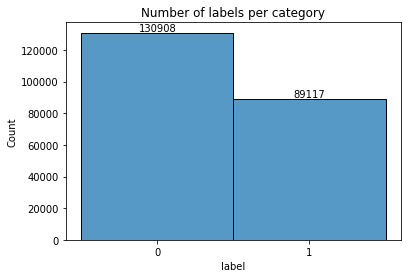

In [9]:
ax = sns.histplot(data.label.astype('str'))
add_histogram_values(ax)
ax.set_title('Number of labels per category');

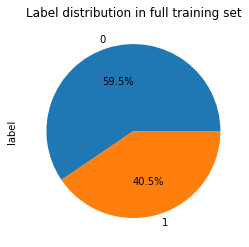

In [10]:
def plot_pie_label_chart(df,set_name):
    df.label.value_counts().plot(kind='pie',
                              title='Label distribution in {} set'.format(set_name),
                              autopct='%1.1f%%')
plot_pie_label_chart(data, 'full training')

Displaying 10 random images of cells without cancer (label=0) and with cancer (label=1)


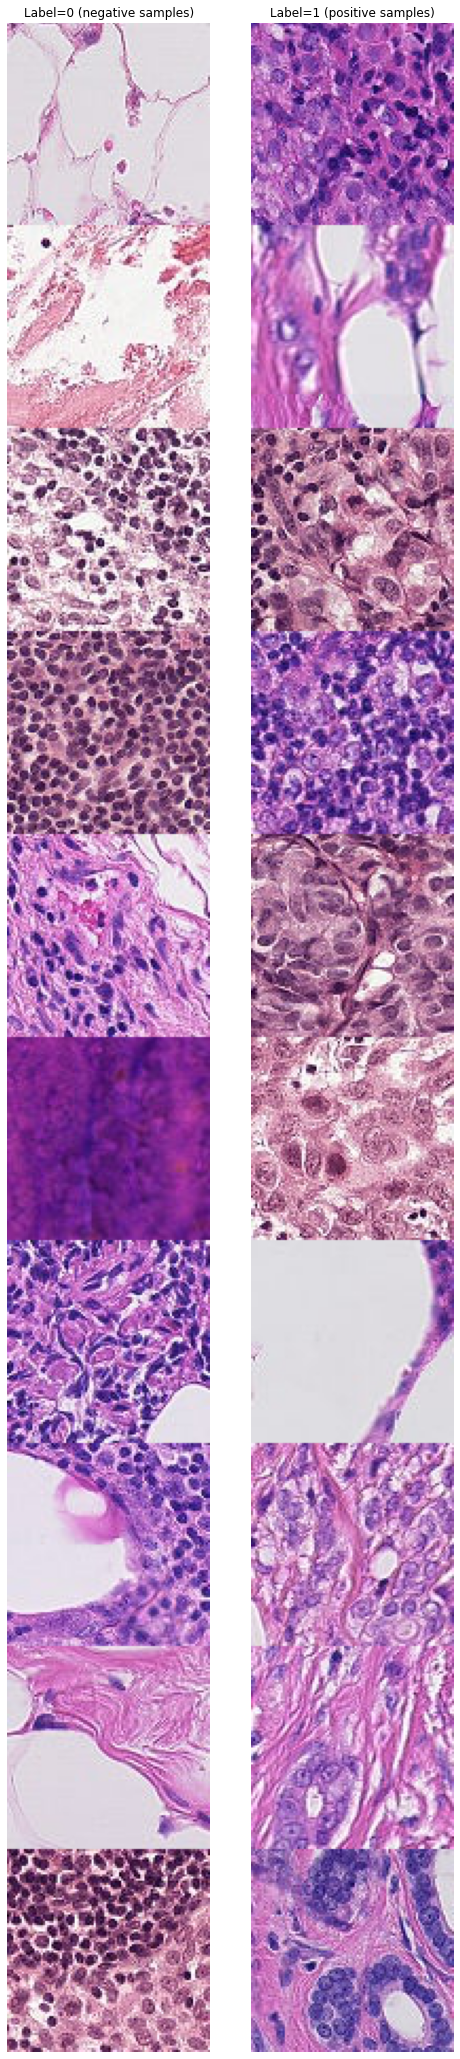

In [11]:
def get_random_ids_by_label(data,lbl=0, n=5):
    ids = data[data['label']==lbl]['id'].values
    np.random.shuffle(ids)
    return ids[0:n]
def plot_random_samples_for_each_class(data,n=10):
    fig, ax = plt.subplots(ncols=2,figsize=(8,n*4));
    ax[0].axis('off')
    ax[1].axis('off')
    idx0 = get_random_ids_by_label(data,0,n)
    imgs_idx0 = [readImage_fromID(ID) for ID in idx0]
    idx1 = get_random_ids_by_label(data,1,n)
    imgs_idx1 = [readImage_fromID(ID) for ID in idx1]
    Img_lbl0 = np.concatenate(imgs_idx0, axis=0)
    Img_lbl1 = np.concatenate(imgs_idx1, axis=0)
    ax[0].imshow(Img_lbl0,aspect='equal')
    ax[1].imshow(Img_lbl1,aspect='equal')
    ax[0].set_title('Label=0 (negative samples)');
    ax[1].set_title('Label=1 (positive samples)');
# Plot some images
n=10
print('Displaying {} random images of cells without cancer (label=0) and with cancer (label=1)'.format(n))
plot_random_samples_for_each_class(data,n)

**Data Cleaning**

* Cleaning the data would require us to inspect the dataset for corrupt or strange images. 
* To detect corrupt files, we will try to load each image and keep a record of any error that occurs
* To detect strange images among 200k images, we would need to build an anomaly detection model, which is out of the scope of  this excercise.
* Duplicated images could exist, but since we will be applying random data transformations on images, this may not cause problems.


In [12]:
print('There are {} unique IDs in training data out of {} IDs'.format(len(set(data.id)),len(data)))

There are 220025 unique IDs in training data out of 220025 IDs


In [13]:
def raggregateead_all_training_images(data):
    except_dict = {}
    for ID in tqdm(list(data.id.values)):
        try:
            readImage_fromID(ID)            
        except Exception as e:
            except_dict[ID]=e
    return except_dict


if check_image_files:
    except_dict = read_all_training_images(data)
    print(except_dict)
                                           
    
    

**Summary**
* No corrupt files were found
* No duplicated IDs were found
* Did not check for anomalous images or repeated images

<a id='section3'></a>

# 3. Model Architecture (25 pts)
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

## ImageDataGenerator

Loading 200k images into memory is not a good alternative. Hence, we will be working with an image data generator that reads the images in the folder based on the image IDs passed as a dataframe. This will also be helpful to apply some preprocessing and image transformations. As preprocessing, rescale pixel values from 0-255 to 0.0-1.1. As transformations, we will randomly apply image flips, rotations, brightness and zoom changes.

In [14]:
# Image data generation
datagen=ImageDataGenerator(rescale=1./255.,
                          horizontal_flip = True,
                          vertical_flip = True,
                          brightness_range = [0.5, 1.5],
                          rotation_range = 15,
                          shear_range = 0.2,
                          zoom_range = 0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
def append_ext(fn):
    return fn + ".tif"
# Modify ids to represent image filenames. Split data into train and validation sets
train_df, val_df = train_test_split(data,train_size=0.8,stratify=data.label)
train_df['id'] = train_df.id.apply(append_ext)
val_df['id'] = val_df.id.apply(append_ext)
print('Validation set:')    
display(val_df)

Validation set:


id  label
49272   30be71454d9d7afdc2d4239d470d85243272ea7a.tif      0
51259   87483932cf5f014b285e640ea2d8136cb2fea601.tif      0
28546   8fec97203ac4ef6d71a0576bfe26a16fb551e89d.tif      0
215264  8d1f607d844083867c327572527f664725c2b28d.tif      0
186129  166f9a0e5a2862b3192bb7c1a9f00e9db9213a08.tif      0
...                                              ...    ...
44635   6a09a34388b6cf591952fea1c89b542ca9cbf854.tif      0
181911  89f321ea6ca9d50393c5739611a7c39e80c6946e.tif      1
97927   a9c48fe9c036eac5ee6a869d777ee2e8e2615942.tif      0
91109   b345879b5a4c616edddb6d194ca2eaffd8fbb825.tif      1
164761  db61541ab8dffc40cd88547f25c65e4d352bba96.tif      1

[44005 rows x 2 columns]

In [16]:
%%time

# Build image generators
IMG_SIZE = (IMG_SHAPE[0],IMG_SHAPE[1])
BATCH_SIZE = 64
def create_generators(train_df,val_df,test_df):
    print('Building train image generator...')
    train_generator = datagen.flow_from_dataframe(
        dataframe = train_df,
        directory = train_folder,
        x_col = 'id',
        y_col = 'label',
        batch_size = BATCH_SIZE,
        class_mode = 'raw',
        target_size = IMG_SIZE,
        color_mode="rgb",
    )
    print('Building validation image generator...')
    val_generator = datagen.flow_from_dataframe(
        dataframe = val_df,
        directory = train_folder,
        x_col = 'id',
        y_col = 'label',
        batch_size = BATCH_SIZE,
        class_mode = 'raw',
        target_size = IMG_SIZE,
        color_mode="rgb",
    )

    print('Building test image generator...')
    test_generator = test_datagen.flow_from_dataframe(
        dataframe = test_df,
        directory = test_folder,
        target_size = IMG_SIZE,
        x_col = 'id',
        y_col = None,
        color_mode="rgb",
        batch_size=1,
        class_mode=None,
        shuffle=False,
        classes = ['.']
    )
    print('...Done')
    return train_generator, val_generator, test_generator

# This will be used for hyperparameter tuning
train_generator_small, val_generator_small, test_generator = create_generators(train_df[0:16000],val_df[0:2000],test_df)

if reduce_dataset_size:
    train_generator, val_generator = train_generator_small, val_generator_small
else:
    train_generator, val_generator, test_generator = create_generators(train_df,val_df,test_df)
        

Building train image generator...
Found 16000 validated image filenames.
Building validation image generator...
Found 2000 validated image filenames.
Building test image generator...


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="None"
  .format(self.class_mode))


Found 57458 validated image filenames.
...Done
CPU times: user 1.11 s, sys: 1.58 s, total: 2.69 s
Wall time: 1min 58s


Inspecting first training image batch:


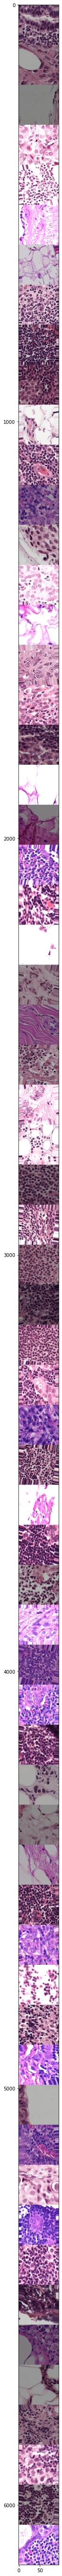

In [17]:
print("Inspecting first training image batch:")
fig,ax = plt.subplots(1,1,figsize=(100,100))
ax.imshow(cv2.vconcat(train_generator[0][0]));

## Proposed architecture

I will be using a convolutional neural network. A very basic model, called model 1, will be compiled but not trained, because training it may take many hours. As hyperparameter, the number of succesive 2D filters will be varied between 2, 4 and 6.

For a second model, I will implement transfer learning from a pretrained model (**Xception** model) trained on imagenet dataset, which is able to distinguish 1000 classes. The classification layer of this will be removed, which will be and replaced by 2 fully connected layers, the latter of which passes the output to a sigmoid activation function to represent the probability of the image being a from cancer cells (1) or not (0). The base model will be used as a feature extractor, and these 2 fully connected layers will be a pretrained model.

In [18]:
# Create a basic CNN
def create_basic_cnn_model(hyperparams):
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = hyperparams.Int("first_filter_depth",min_value=2,max_value=6,step=2,default=4)
    second_filters = 8
    third_filters = 16

    dropout_conv = hyperparams.Float("dropout_conv",min_value=0.1,max_value=0.5,step=0.2,default=0.3)
    dropout_dense = 0.3


    model1 = Sequential(name='basic_CNN_model')
    model1.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = IMG_SHAPE))
    model1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model1.add(MaxPooling2D(pool_size = pool_size)) 
    model1.add(Dropout(dropout_conv))

    model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model1.add(MaxPooling2D(pool_size = pool_size))
    model1.add(Dropout(dropout_conv))

    model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model1.add(MaxPooling2D(pool_size = pool_size))
    model1.add(Dropout(dropout_conv))

    model1.add(Flatten())
    model1.add(Dense(256, activation = "relu"))
    model1.add(Dropout(dropout_dense))
    model1.add(Dense(1, activation = "sigmoid"))
    
    # Compile basic model
    model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model1
model1 =    create_basic_cnn_model(kt.HyperParameters())
model1.summary()

Model: "basic_CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 4)         112       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 4)         148       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 4)         148       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 4)         0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 4)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 8)         296       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 8)     

2022-12-22 21:37:38.082818: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


basic_CNN_model:



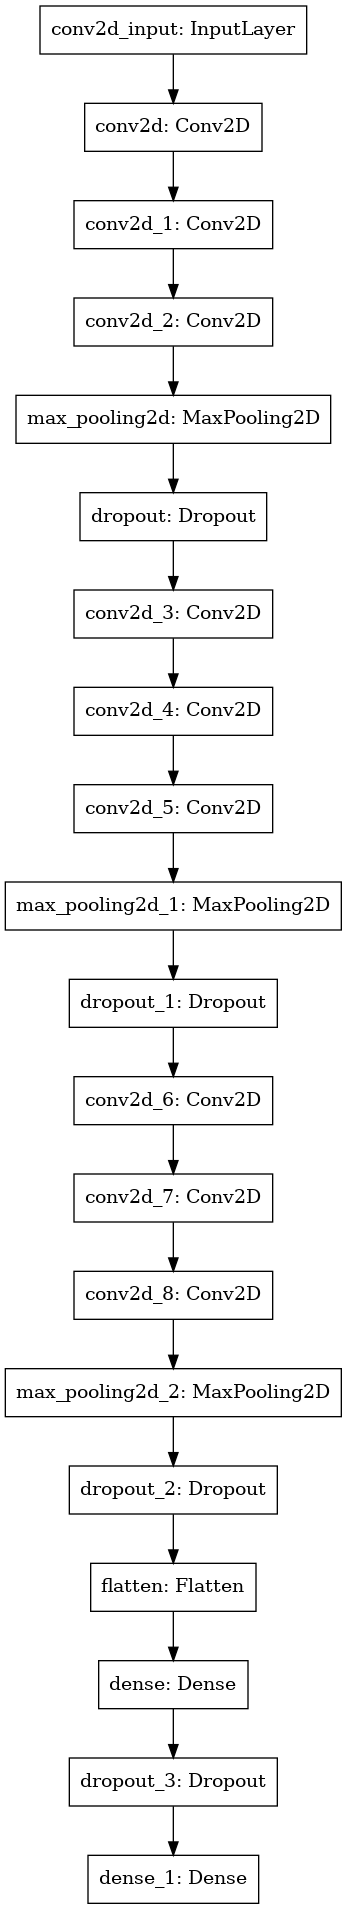

In [19]:
# Draw basic model
print(model1.name+':\n')
tf.keras.utils.plot_model(model1)

## Transfer Learning

Training a model from scratch can be time consuming. The following links describe how to implement transfer learning.
* [Keras - Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/)
* [Keras - Applications / Fine-tune InceptionV3 on a new set of classes](https://keras.io/api/applications/#usage-examples-for-image-classification-models)

I will be using the Xception model from Keras, which contains over 20M pretrained weights over the imagenet dataset, where it can achieve a accuracy 94% score.

In [20]:
# Load base model for transfer learning
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3),
    pooling=None,
)
base_model.summary()

83697664/83683744 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 47, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 47, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 47, 47, 32)   0           block1_conv1_bn[0][0]            
__________________________

Base model taken for transfer learning learning (name = xception)



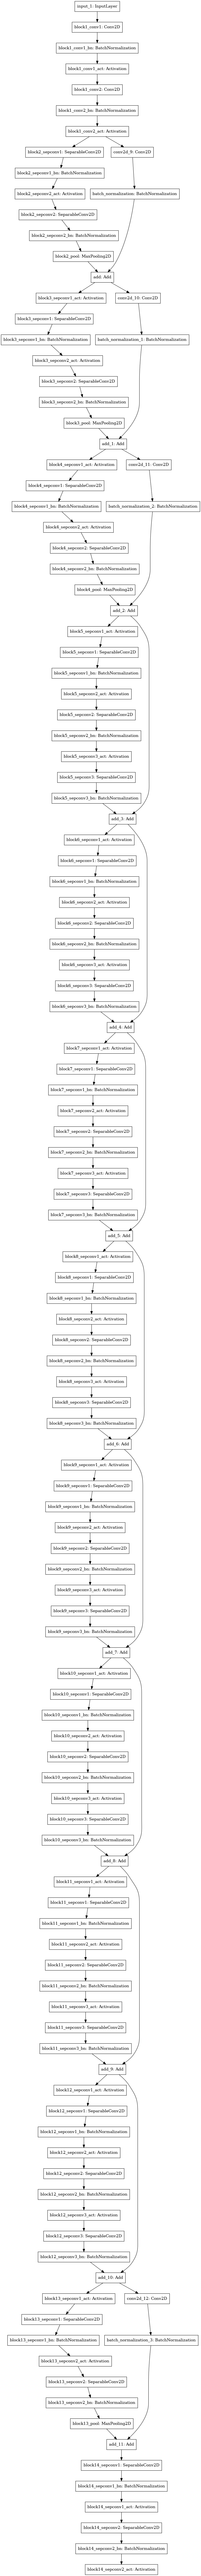

In [21]:
print('Base model taken for transfer learning learning (name = {})\n'.format(base_model.name))
tf.keras.utils.plot_model(base_model)

In [22]:
base_model.trainable = False # Freeze model parameters of base model
inputs = tf.keras.Input(shape=(IMG_SHAPE))
# Add classification layers on top of base model
x = base_model(inputs,training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(10,activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(1,activation='sigmoid')(x)

In [23]:
# this is the transfer learning model we will train
tl_model = Model(inputs, outputs,name='transfer_learning_xception')
tl_model.summary()

Model: "transfer_learning_xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20490     
_________________________________________________________________
batch_normalization_4 (Batch (None, 10)                40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 20,882,021
Trainable params: 20,521
Non-trainable params: 20,861,500
_______________________

Transfer learning model:



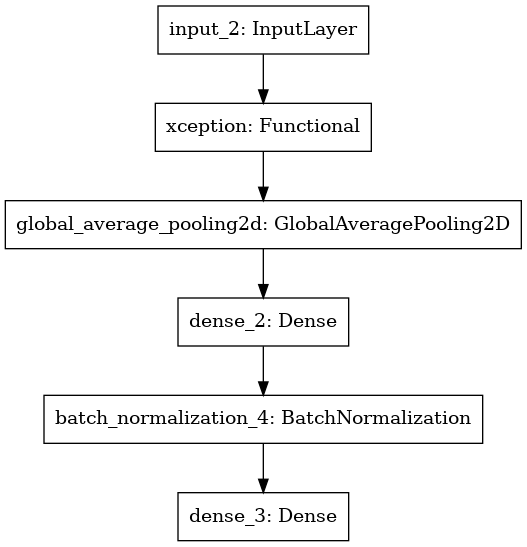

In [24]:
print('Transfer learning model:\n')
tf.keras.utils.plot_model(tl_model)

In [25]:
tl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Results and Analysis (35 pts) 

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

# Hyperparameter optimization
Considering the basic model, we will vary the depth of the first set of convolutions and the dropout ratio for the convolution layers. 

Due to the computational cost, we will tune hyperparameter with keras tuner but working only with small fraction of the dataset and 5 epochs.

In [26]:
# Use Keras Tuner for Hyperparameter optimization with the basic CNN model
tuner = kt.RandomSearch(
    hypermodel = create_basic_cnn_model,
    objective="val_accuracy",
    max_trials=8,
    executions_per_trial = 1 ,
    overwrite=True,
    directory=save_folder,
    project_name="basic_model_tuning",
)
tuner.search_space_summary()

Search space summary
Default search space size: 2
first_filter_depth (Int)
{'default': 4, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 2, 'sampling': None}
dropout_conv (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.2, 'sampling': None}


In [27]:
# Print available gpu device
print('The GPU being used is:')
tf.test.gpu_device_name()

The GPU being used is:


''

In [28]:
# Tune in a smaller dataset for few epochs
tuner.search(train_generator_small, epochs=5, validation_data=val_generator_small,verbose=1)

Trial 5 Complete [00h 05m 58s]
val_accuracy: 0.7524999976158142

Best val_accuracy So Far: 0.7670000195503235
Total elapsed time: 00h 31m 35s


In [29]:
# Select model hyperparameters to maximize accuracy
models = tuner.get_best_models(num_models=1)
model1 = models[0] # best model
model1.summary()

Model: "basic_CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 6)         168       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 6)         330       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 6)         330       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 6)         0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 8)         440       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 8)     

## Train models (this is the slowest part)

In [30]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-2, verbose=1, mode='auto', baseline=0.999)

In [31]:
%%time
# Train basic model with selected hyperparameters
if train_basic_model:
    STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID = val_generator.n//val_generator.batch_size
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
    model1.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = N_EPOCHS,
                    verbose = 1,
                    callbacks=[reduce_lr, early_stopping]
    )

Epoch 1/50
250/250 [==============================] - 73s 289ms/step - loss: 0.4992 - accuracy: 0.7673 - val_loss: 0.5090 - val_accuracy: 0.7661
Epoch 2/50
250/250 [==============================] - 73s 292ms/step - loss: 0.4909 - accuracy: 0.7730 - val_loss: 0.5217 - val_accuracy: 0.7525
Epoch 3/50
250/250 [==============================] - 72s 289ms/step - loss: 0.4917 - accuracy: 0.7682 - val_loss: 0.5276 - val_accuracy: 0.7490
Epoch 4/50
250/250 [==============================] - 72s 290ms/step - loss: 0.4825 - accuracy: 0.7779 - val_loss: 0.5063 - val_accuracy: 0.7606
Epoch 5/50
250/250 [==============================] - 72s 288ms/step - loss: 0.4882 - accuracy: 0.7701 - val_loss: 0.4888 - val_accuracy: 0.7681
Epoch 6/50
250/250 [==============================] - 72s 287ms/step - loss: 0.4750 - accuracy: 0.7784 - val_loss: 0.4868 - val_accuracy: 0.7737
Epoch 7/50
250/250 [==============================] - 72s 288ms/step - loss: 0.4764 - accuracy: 0.7781 - val_loss: 0.4790 - val_ac

In [32]:
# Save results
save_path_m1 = os.path.join(save_folder,model1.name)
model1.save(filepath = save_path_m1)

2022-12-22 22:58:42.369709: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [33]:
%%time
# Train transfer learning model (no hyperparameter tuning is done here)
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
tl_model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = N_EPOCHS,
                    verbose = 1
)

Epoch 1/50
250/250 [==============================] - 220s 870ms/step - loss: 0.4824 - accuracy: 0.7778 - val_loss: 0.4729 - val_accuracy: 0.7807
Epoch 2/50
250/250 [==============================] - 217s 867ms/step - loss: 0.4261 - accuracy: 0.8066 - val_loss: 0.4307 - val_accuracy: 0.8029
Epoch 3/50
250/250 [==============================] - 216s 864ms/step - loss: 0.4091 - accuracy: 0.8161 - val_loss: 0.4248 - val_accuracy: 0.8165
Epoch 4/50
250/250 [==============================] - 215s 860ms/step - loss: 0.4037 - accuracy: 0.8202 - val_loss: 0.4046 - val_accuracy: 0.8261
Epoch 5/50
250/250 [==============================] - 216s 862ms/step - loss: 0.3994 - accuracy: 0.8197 - val_loss: 0.4127 - val_accuracy: 0.8075
Epoch 6/50
250/250 [==============================] - 216s 866ms/step - loss: 0.3977 - accuracy: 0.8200 - val_loss: 0.4036 - val_accuracy: 0.8216
Epoch 7/50
250/250 [==============================] - 220s 880ms/step - loss: 0.3942 - accuracy: 0.8270 - val_loss: 0.4112 -

In [34]:
save_path_tl = os.path.join(save_folder,tl_model.name)
tl_model.save(filepath = save_path_tl)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Evaluate results: model learning curves during training
We have used accuracy as the objective function. Let us inspect how training and validation accuracy change with then number of epochs

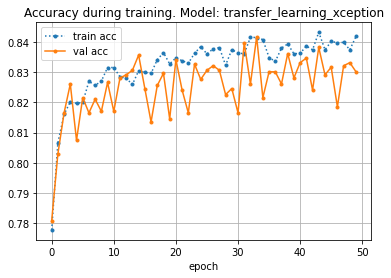

In [35]:
def plot_model_training_curve(model):
    plt.plot(model.history.history['accuracy'],'.:',label='train acc')
    plt.plot(model.history.history['val_accuracy'],'.-',label='val acc');
    plt.xlabel('epoch')
    plt.grid()
    plt.title('Accuracy during training. Model: {}'.format(model.name))
    plt.legend();

plot_model_training_curve(tl_model)

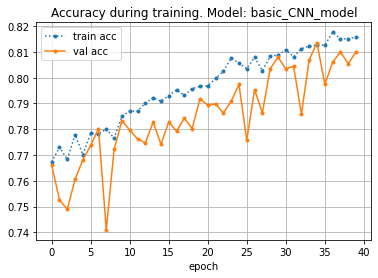

In [36]:
if train_basic_model:
    plot_model_training_curve(model1)

## ROC and AUC
The area under the curve is the intended metric to evaluate our models. Let us prepare the ROC plot and compute AUC.

In [37]:
def get_validation_predictions_from_generator(model,val_generator):
    orig_shuffle_state = val_generator.shuffle
    val_generator.reset()
    val_generator.shuffle = False
    yval_probs = np.zeros(val_generator.samples).astype(np.float32)
    y_val_true =  np.zeros(val_generator.samples).astype(np.float32)
    b = val_generator.batch_size
    for i in tqdm(range(int(np.ceil(val_generator.n/val_generator.batch_size))),desc='Computing predictions from generator'):    
        Xi, yi = val_generator.__getitem__(i) 
        ind = range(i*b,i*b+len(yi))
        y_val_true[ind] = yi
        yi_pred = model.predict(Xi,verbose=0)
        yval_probs[ind] = yi_pred.flatten()
    val_generator.shuffle = orig_shuffle_state    
    return y_val_true, yval_probs

Computing predictions from generator: 100%|██████████| 32/32 [00:29<00:00,  1.07it/s]


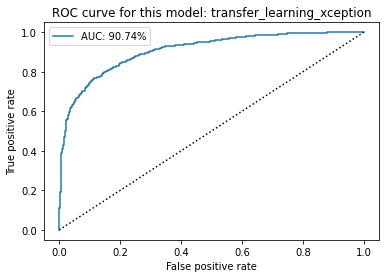

In [38]:
def plot_validation_ROC_curve(model,val_generator):
    y_val_true, yval_probs = get_validation_predictions_from_generator(model,val_generator)    
    fpr, tpr, thresholds = metrics.roc_curve(y_val_true,yval_probs)
    AUC = metrics.auc(fpr,tpr)
    
    fig,ax = plt.subplots(1,1)
    ax.plot(fpr,tpr,label='AUC: {:.2f}%'.format(AUC*100))
    ax.plot(fpr,fpr,'k:')
    ax.set_title('ROC curve for this model: {}'.format(model.name));
    ax.set_xlabel('False positive rate');
    ax.set_ylabel('True positive rate');
    ax.legend();
    return fig, ax, AUC

fig, ax, AUC_tl = plot_validation_ROC_curve(tl_model,val_generator) 

Computing predictions from generator: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


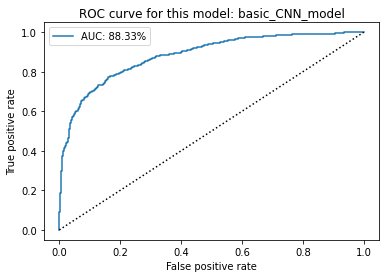

In [39]:
if train_basic_model:
    fig, ax, AUC_m1  = plot_validation_ROC_curve(model1,val_generator) 

# 5. Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

## Discussion
* The model based on transfer learning performs better in this case than the basic CNN model, as seen from the AUC and ROC curves
* Each training epoch takes a long time to compute due to the number of samples. However, increasing the number of epochs might help, but it is not clear due to  oscillations in the validation accuracy.
* Due to the limit of GPU usage in kaggle, I am not running longer computations and will not attempt to unfreeze some layers of the base model used for transfer learning.

# Takeaways
* The imagedatagenerators allow us to work with many images without loading them in the memory. They can also be used to increase the size of the dataset
* The use of AUC is suitable to compare these models, and a threshold should be defined that minimizes the risk of False Negatives, given the application at hand.
* Tuning the hyparameters with the full dataset is too slow in this application.
* The model based on transfer learning performs better in this case than the basic CNN model.

## Future work
It is suggested to try:
* Using different optimization methods
* Unfreezing some of the last layers of the model taken for transfer learning
* Reducing the image size to capture the center 32x32 pixel region of the images
* Generating more data for training with the image generators
* TRaining a random forest model as a classifier that takes the transfer learning model as input
* Using other base models for transfer learning

In [40]:
def get_test_predictions_from_generator(model,test_generator,threshold=None):
    predictions = model.predict(test_generator,verbose=1).flatten()     
    if threshold is None:
        # return probabilities  
        return predictions.round(4)
    else:
        # return 0 or 1
        return (predictions>threshold).astype(int)
          
if train_basic_model:
    print('Computing test set predictions with this model: {}'.format(model1.name))
    predictions_model1 = get_test_predictions_from_generator(model1,test_generator)

print('Computing test set predictions with this model: {}'.format(tl_model.name))
predictions_tl_model = get_test_predictions_from_generator(tl_model,test_generator)

Computing test set predictions with this model: basic_CNN_model
57458/57458 [==============================] - 376s 7ms/step
Computing test set predictions with this model: transfer_learning_xception
57458/57458 [==============================] - 2205s 38ms/step


In [41]:
def remove_extension(filename_list):
    return [id.split('.')[0] for id in filename_list]

submit_df = pd.DataFrame({'id': remove_extension(test_df.id),
                          'label': predictions_tl_model})
submit_df

id   label
0      a7ea26360815d8492433b14cd8318607bcf99d9e  0.7413
1      59d21133c845dff1ebc7a0c7cf40c145ea9e9664  0.2151
2      5fde41ce8c6048a5c2f38eca12d6528fa312cdbb  0.0871
3      bd953a3b1db1f7041ee95ff482594c4f46c73ed0  0.3937
4      523fc2efd7aba53e597ab0f69cc2cbded7a6ce62  0.3162
...                                         ...     ...
57453  7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b  0.0283
57454  2a6fc1ed16fa94d263efab330ccbeb1906cbd421  0.2894
57455  6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14  0.7672
57456  f11e7c9e77cbc1ec916a52e6b871a293ee1bb928  0.0066
57457  66d529ceeb28e822fac5e1378cc5702194532127  0.0379

[57458 rows x 2 columns]

Distribution of predicted categories:



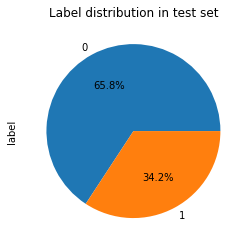

In [42]:
print('Distribution of predicted categories:\n')
submit_df2 = submit_df.copy()
submit_df2['label'] = (submit_df2['label']>0.5).astype(int)
plot_pie_label_chart(submit_df2, 'test')

In [43]:
# Competition Submission
submit_df.to_csv('submission.csv', index=False)